# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [2]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import time
import pandas as pd
import io

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist
import cv2

## Setting up network and loading weights

In [3]:
# model_name = "mono_1024x320"
# model_name = "mono_apollo_640x512/models/weights_5"
model_name = "mono_city_512x256/models/weights_0"

# download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

depth_decoder.load_state_dict(torch.load(depth_decoder_path))

encoder.eval()
depth_decoder.eval()

pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")

pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval();

## Loading the test image and preprocessing

In [42]:
# image_path1 = '/home/ubuntu/hdd/data/Apolloscape/Segmentation/road04_seg/ColorImage/Record021/Camera 5/171206_062301655_Camera_5.jpg'
# image_path2 = '/home/ubuntu/hdd/data/Apolloscape/Segmentation/road04_seg/ColorImage/Record021/Camera 5/171206_062301924_Camera_5.jpg'
label_path1 = '/home/ubuntu/hdd/data/Apolloscape/Segmentation/road04_seg/Label/Record021/Camera 5/171206_062301655_Camera_5_bin.png'
label_path2 = '/home/ubuntu/hdd/data/Apolloscape/Segmentation/road04_seg/Label/Record021/Camera 5/171206_062301924_Camera_5_bin.png'

# image_path1 = '/home/ubuntu/hdd/data/kitti/RawData/2011_09_30/2011_09_30_drive_0020_sync/image_02/data/0000000000.png'
# image_path2 = '/home/ubuntu/hdd/data/kitti/RawData/2011_09_30/2011_09_30_drive_0020_sync/image_02/data/0000000001.png'
image_path1 = '/home/ubuntu/hdd/data/Cityscapes/leftImg8bit_sequence_trainvaltest/leftImg8bit_sequence/train/aachen/aachen_000011_000000_leftImg8bit.png'
image_path2 = '/home/ubuntu/hdd/data/Cityscapes/leftImg8bit_sequence_trainvaltest/leftImg8bit_sequence/train/aachen/aachen_000011_000001_leftImg8bit.png'

input_image1 = pil.open(image_path1).convert('RGB')
input_image2 = pil.open(image_path2).convert('RGB')
label1 = pil.open(label_path1).convert('RGB')
label2 = pil.open(label_path2).convert('RGB')
original_width, original_height = input_image1.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image1_resized = input_image1.resize((feed_width, feed_height), pil.LANCZOS)
input_image2_resized = input_image2.resize((feed_width, feed_height), pil.LANCZOS)
label1_resized = label1.resize((feed_width, feed_height), pil.LANCZOS)
label2_resized = label2.resize((feed_width, feed_height), pil.LANCZOS)

input_image1_pytorch = transforms.ToTensor()(input_image1_resized).unsqueeze(0).cuda()
input_image2_pytorch = transforms.ToTensor()(input_image2_resized).unsqueeze(0).cuda()
label1_pytorch = torch.FloatTensor(np.array(label1_resized).transpose(2, 0, 1)).unsqueeze(0).cuda()
label2_pytorch = torch.FloatTensor(np.array(label2_resized).transpose(2, 0, 1)).unsqueeze(0).cuda()

## Prediction using the PyTorch model

In [43]:
t = time.time()
with torch.no_grad():
    features = encoder(torch.cat([input_image1_pytorch, input_image2_pytorch], 0))
    outputs = depth_decoder(features)
    disp1 = outputs[("disp", 0)][0]
    disp2 = outputs[("disp", 0)][1]
    features_pose = [pose_encoder(torch.cat([input_image1_pytorch, input_image2_pytorch], 1))]
    axisangle, translation = pose_decoder(features_pose)
    torch.cuda.synchronize()
print(time.time()-t)

0.01015019416809082


## Plotting

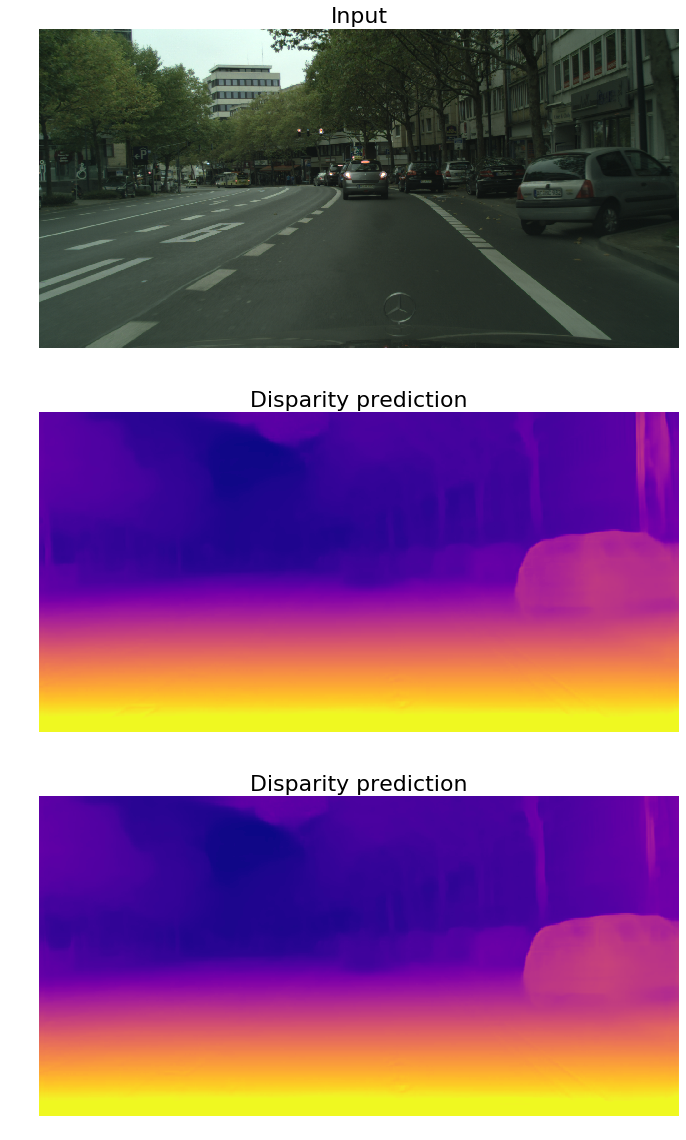

In [44]:
# disp_resized = torch.nn.functional.interpolate(disp,
#     (original_height, original_width), mode="bilinear", align_corners=False)

disp1_np = disp1.squeeze().cpu().numpy()
disp2_np = disp2.squeeze().cpu().numpy()
vmax = np.percentile(disp1_np, 95)

plt.figure(figsize=(20, 20))
plt.subplot(311)
plt.imshow(input_image1)
plt.title("Input", fontsize=22)
plt.axis('off');

plt.subplot(312)
plt.imshow(disp1_np, cmap='plasma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

plt.subplot(313)
plt.imshow(disp2_np, cmap='plasma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');
# plt.subplot(313)
# plt.imshow(depth_np, cmap='jet', vmax=100)
# plt.title("Depth prediction", fontsize=22)
# plt.axis('off');

In [45]:
import yaml
from layers import *
# with open('/home/ubuntu/hdd/data/kitti/RawData/2011_09_30/calib_cam_to_cam.txt', 'r') as f:
#     calib_cam = yaml.load(f)
    
# K = np.fromstring(calib_cam['P_rect_02'], dtype=np.float32, sep=' ').reshape(3, 4)
# K[:, -1] = 0
# K = np.concatenate([K, np.array([0, 0, 0, 1]).reshape(1, 4)], axis=0)
# K[0] *= feed_width/original_width
# K[1] *= feed_height/original_height

# fx = 2304.54786556982
# fy = 2305.87566806200
# cx = 1686.23787612802
# cy = 1354.98486439791

fx = 2262.52
fy = 2265.3017905988554
cx = 1096.98
cy = 513.137

K = np.array([[fx, 0, cx, 0],
               [0, fy, cy, 0],
               [0,        0,        1, 0],
               [0,        0,        0, 1]], dtype=np.float32)
K[0] *= feed_width/original_width
K[1] *= feed_height/original_height

K_inv = np.linalg.inv(K)

In [46]:
disp1_, depth1 = disp_to_depth(disp1, 0.1, 100)
disp2_, depth2 = disp_to_depth(disp2, 0.1, 100)
backproject_depth = BackprojectDepth(1, feed_height, feed_width).cuda()
project_3d = Project3D(1, feed_height, feed_width).cuda()

t = time.time()
cam_points = backproject_depth(depth2, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())
T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], True)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis,:]).cuda(), T)

with torch.no_grad():
    img_warped12 = F.grid_sample(input_image1_pytorch, pix_coords, padding_mode="border")
    label_warped12 = F.grid_sample(label1_pytorch, pix_coords, mode='nearest', padding_mode="border")
    
cam_points = backproject_depth(depth1, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())
T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], False)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis,:]).cuda(), T)

with torch.no_grad():
    img_warped21 = F.grid_sample(input_image2_pytorch, pix_coords, padding_mode="border")
    label_warped21 = F.grid_sample(label2_pytorch, pix_coords, mode='nearest', padding_mode="border")
    
print(T)
torch.cuda.synchronize()
print(time.time()-t)

tensor([[[ 1.0000e+00,  2.5319e-03,  5.1293e-05,  7.3538e-05],
         [-2.5319e-03,  1.0000e+00, -1.0921e-05,  8.0488e-04],
         [-5.1321e-05,  1.0791e-05,  1.0000e+00, -2.1238e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
0.0053217411041259766


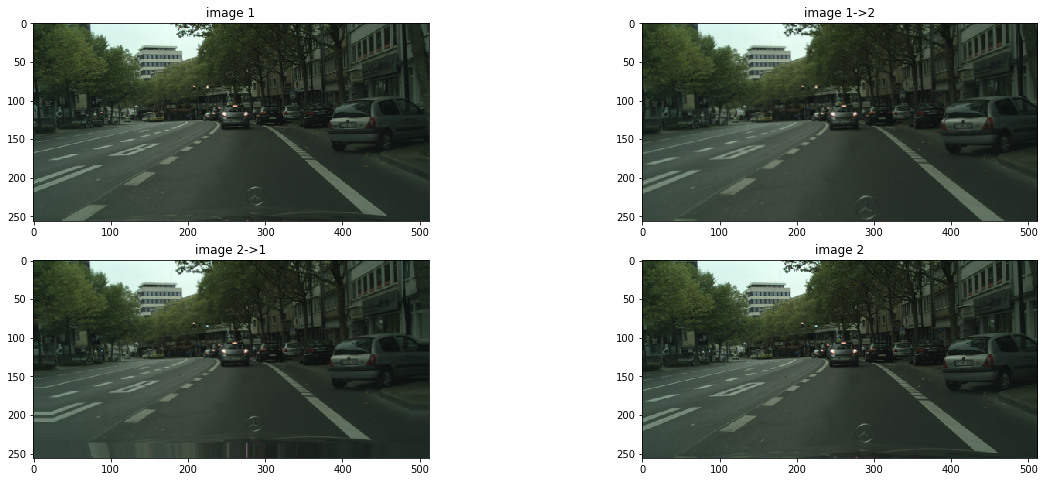

In [47]:
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.title('image 1')
plt.imshow(input_image1_pytorch.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(222)
plt.title('image 1->2')
plt.imshow(img_warped12.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(223)
plt.title('image 2->1')
plt.imshow(img_warped21.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(224)
plt.title('image 2')
plt.imshow(input_image2_pytorch.cpu().numpy()[0].transpose(1, 2, 0))

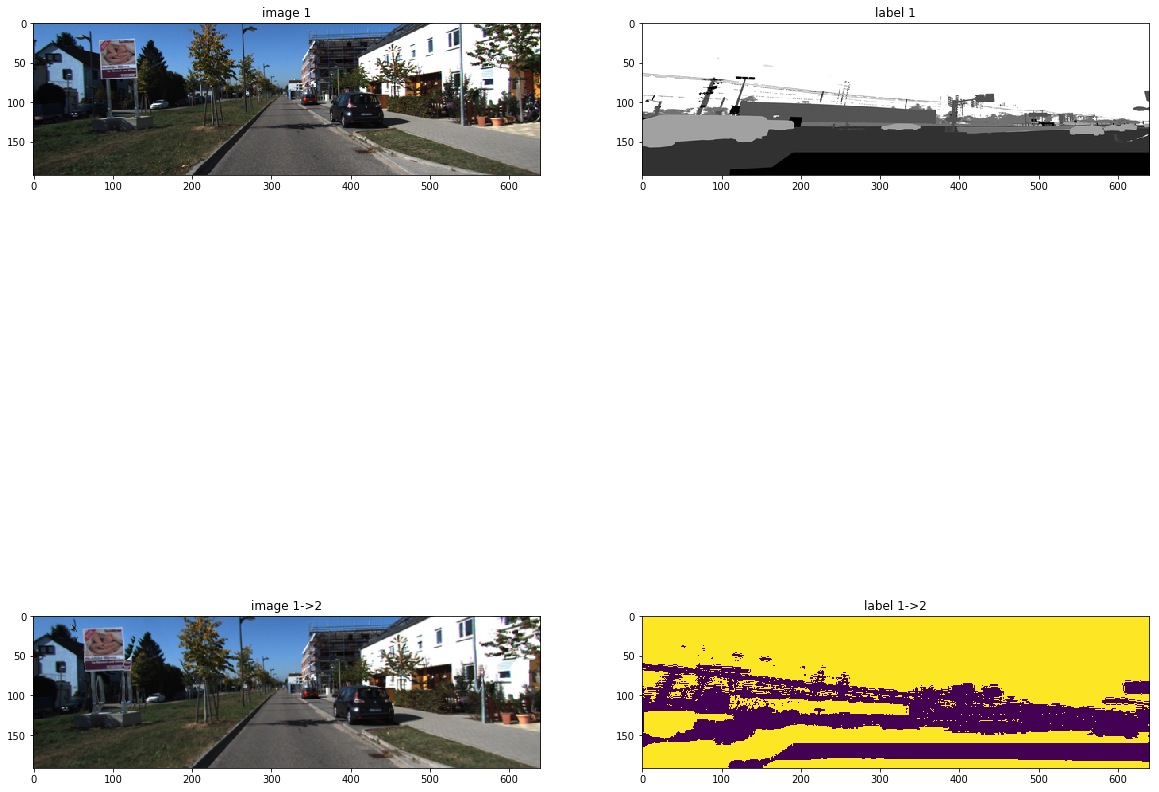

In [367]:
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.title('image 1')
plt.imshow(input_image1_pytorch.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(222)
plt.title('label 1')
plt.imshow(label1_pytorch.cpu().numpy()[0].transpose(1, 2, 0)/255.0)
plt.subplot(223)
plt.title('image 1->2')
plt.imshow(img_warped12.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(224)
plt.title('label 1->2')
plt.imshow(torch.all(label2_pytorch==label_warped12, dim=1).cpu().numpy()[0])

# Create video

In [20]:
prev_img = None
orig = np.array([0, 0, 0, 1])
pos_gt = [orig.copy()]
pos_pred = [orig.copy()]

# seg = 'road04_seg'
# record = 'Record021'
# record_dir = '/home/ubuntu/hdd/data/Apolloscape/Segmentation/%s/ColorImage/%s/Camera 5'%(seg, record)
# vid_name = '%s_%s.avi'%(seg, record)

record_dir = '/home/ubuntu/hdd/data/kitti/RawData/2011_09_30/2011_09_30_drive_0033_sync/image_02/data/'
vid_name = '2011_09_30_drive_0033_2.avi'

# pose_gt = pd.read_csv('/home/ubuntu/hdd/data/Apolloscape/Segmentation/%s/Pose/%s/Camera 5/pose.txt'%(seg, record), sep=' ', header=None)
# pose_gt.sort_values(16, inplace=True)
# pose_gt.drop(pose_gt.columns[16], axis=1, inplace=True)
# pose_gt = np.array(pose_gt, dtype=np.float32).reshape(-1, 4, 4)

pose_gt = pd.read_csv('/home/ubuntu/hdd/data/kitti/odometry/poses/09.txt', sep=' ', header=None)
pose_gt[12] = 0
pose_gt[13] = 0
pose_gt[14] = 0
pose_gt[15] = 1
pose_gt = np.array(pose_gt, dtype=np.float32).reshape(-1, 4, 4)

out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'XVID'), 10.0, (feed_width*2+320,feed_height))
T_pred = []
T_gt = np.eye(4)
T_pr = np.eye(4)
for i, filename in enumerate(sorted(os.listdir(record_dir))):
    image_path = os.path.join(record_dir, filename)
    input_image = pil.open(image_path).convert('RGB')
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0).cuda()
    
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)
        disp = outputs[("disp", 0)][0]
        if prev_img is not None:
            features_pose = [pose_encoder(torch.cat([prev_img, input_image_pytorch], 1))]
            axisangle, translation = pose_decoder(features_pose)
            T_ = transformation_from_parameters(axisangle[:, 0], translation[:, 0], True).cpu().numpy()[0]
            T_pr = T_pr.dot(T_)
            T_pred += [T_]
            T_gt = T_gt.dot(np.linalg.inv(pose_gt[i-1]).dot(pose_gt[i]))
            pos_gt += [T_gt[:,-1]]
            pos_pred += [T_pr[:,-1]]
    
    disp_np = disp.squeeze().cpu().numpy()
    vmax = np.percentile(disp_np, 95)
    output = np.zeros((feed_height, feed_width*2+320, 3), dtype=np.uint8)
    buf = io.BytesIO()
    plt.imsave(buf, disp_np, cmap='plasma', vmax=vmax)
    buf.seek(0)
    disp_ = np.array(pil.open(buf))[:,:,:3]
    buf.close()
    
    pos_gt_ = np.array(pos_gt)
    plt.figure(figsize=(5, 5))
    plt.title("Visual odometry", fontsize=15)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    plt.plot(pos_gt_[:, 0], pos_gt_[:, 2], 'o-', label='gt')
    scale = 29.5
    pos_pred_ = np.array(pos_pred)*scale
    plt.plot(pos_pred_[:, 0], pos_pred_[:, 2], 'o-', label='pred')
    plt.scatter(pos_pred_[-1, 0], pos_pred_[-1, 2], color='r', s=100, zorder=10)
    plt.text(pos_pred_[-1, 0], pos_pred_[-1, 2], 'NOW', fontsize=15, zorder=20)
    plt.legend(loc=4, fontsize=15)
    buf = io.BytesIO()
    plt.savefig(buf, dpi=64)
    plt.close()
    buf.seek(0)
    vo = np.array(pil.open(buf))[:,:,:3]
    buf.close()
    
    output[:,:feed_width] = np.array(input_image_resized)
    output[:,feed_width:-320] = disp_
    output[:,-320:] = vo
    out.write(output[:,:,::-1])
    
    prev_img = input_image_pytorch
    print('\r', i+1, len(os.listdir(record_dir)), end=' '*10)
    
    if i==1590:
        break
    
out.release()

 1591 1594          

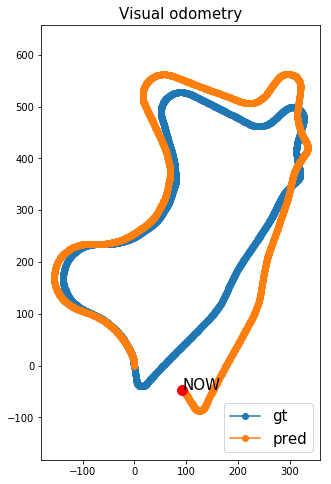

In [27]:
pos_gt = [orig.copy()]
pos_pred = [orig.copy()]

T_gt = np.eye(4)
T_pr = np.eye(4)
for i in range(1, len(pose_gt)):
    T_pr = T_pr.dot(T_pred[i-1])
    T_gt = T_gt.dot(np.linalg.inv(pose_gt[i-1]).dot(pose_gt[i]))
    pos_gt += [T_gt[:,-1]]
    pos_pred += [T_pr[:,-1]]
    
pos_gt = np.array(pos_gt)
plt.figure(figsize=(5, 8))
plt.title("Visual odometry", fontsize=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
plt.plot(pos_gt[:, 0], pos_gt[:, 2], '-o', label='gt')
scale = 34.169
pos_pred = np.array(pos_pred)*scale
plt.plot(pos_pred[:, 0], pos_pred[:, 2], '-o', label='pred')
plt.scatter(pos_pred[-1, 0], pos_pred[-1, 2], color='r', s=100, zorder=10)
plt.text(pos_pred[-1, 0], pos_pred[-1, 2], 'NOW', fontsize=15, zorder=20)
plt.legend(loc=4, fontsize=15)

buf = io.BytesIO()
plt.savefig(buf, dpi=64)
# plt.close()
buf.seek(0)
x = np.array(pil.open(buf))[:,:,:3]
buf.close()